# Bài tập 3.2: Coverage with Voronoi Partition

## Mô tả bài toán
Cho một vùng giám sát dạng đa giác lồi. Hàm mật độ thông tin là:

$$
\Phi(x, y) = e^{-x^2 - y^2}
$$

Sử dụng phân vùng Voronoi và thuật toán Lloyd để phân bố đội hình robot sao cho tối ưu vùng bao phủ.

In [2]:
# Import các thư viện
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

In [3]:
# Định nghĩa hàm mật độ Phi
def phi(x, y):
    return np.exp(-x**2 - y**2)

In [4]:
# Hàm tạo đa giác lồi Q (hình vuông)
def create_convex_polygon():
    return Polygon([(-1.5, -1.5), (-1.5, 1.5), (1.5, 1.5), (1.5, -1.5)])

In [5]:
# Hàm cắt vùng Voronoi với đa giác lồi Q
def clip_voronoi_cell(region_idx, vor, bounds):
    region = vor.regions[region_idx]
    if -1 in region or len(region) == 0:
        return None
    polygon = Polygon([vor.vertices[i] for i in region])
    clipped = polygon.intersection(bounds)
    return clipped if clipped.is_valid and not clipped.is_empty else None

In [6]:
# Tính trọng tâm theo mật độ phi trong một vùng
def compute_weighted_centroid(polygon, density_func, samples=500):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    weights = []
    for _ in range(samples):
        x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
        if polygon.contains(Point(x, y)):
            w = density_func(x, y)
            points.append((x, y))
            weights.append(w)
    points = np.array(points)
    weights = np.array(weights)
    if len(points) == 0:
        return polygon.centroid.x, polygon.centroid.y
    cx = np.average(points[:, 0], weights=weights)
    cy = np.average(points[:, 1], weights=weights)
    return cx, cy

In [7]:
# Chạy thuật toán Lloyd để tối ưu vùng bao phủ
def run_lloyd_algorithm(n_robots=10, iterations=10):
    domain = create_convex_polygon()
    positions = np.random.uniform(-1.2, 1.2, size=(n_robots, 2))
    for _ in range(iterations):
        vor = Voronoi(positions)
        new_positions = []
        for i, point_idx in enumerate(vor.point_region):
            cell = clip_voronoi_cell(point_idx, vor, domain)
            if cell is not None:
                cx, cy = compute_weighted_centroid(cell, phi)
                new_positions.append((cx, cy))
            else:
                new_positions.append(tuple(positions[i]))
        positions = np.array(new_positions)
    return positions, domain

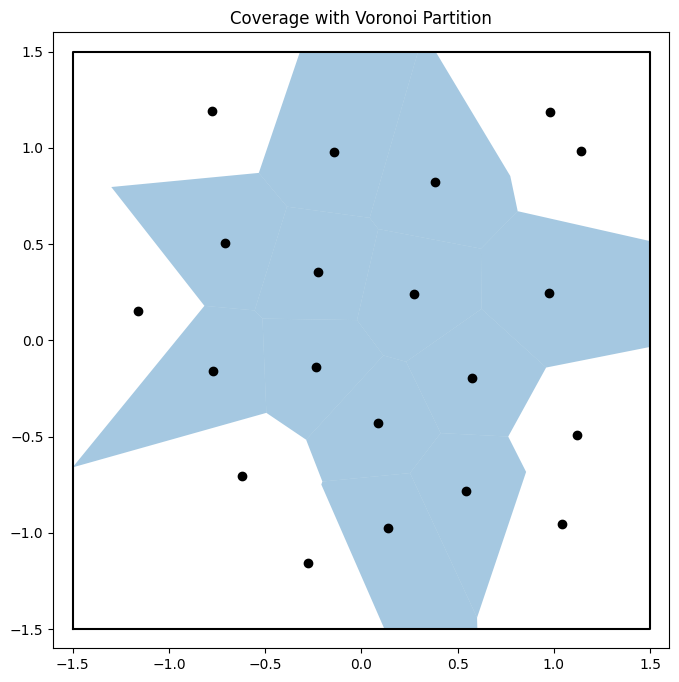

In [8]:
# Vẽ kết quả cuối cùng
positions, domain = run_lloyd_algorithm(n_robots=20, iterations=15)
vor = Voronoi(positions)

fig, ax = plt.subplots(figsize=(8, 8))
patches = []
for idx in range(len(positions)):
    region = clip_voronoi_cell(vor.point_region[idx], vor, domain)
    if region:
        patches.append(MplPolygon(list(region.exterior.coords)))
p = PatchCollection(patches, alpha=0.4)
ax.add_collection(p)
ax.plot(positions[:, 0], positions[:, 1], 'ko')
x, y = domain.exterior.xy
ax.plot(x, y, 'k')
ax.set_xlim(-1.6, 1.6)
ax.set_ylim(-1.6, 1.6)
ax.set_aspect('equal')
ax.set_title("Coverage with Voronoi Partition")
plt.show()